# Raw CaloClouds

Trying to diagnose an issue with the output distirbutions of Showflow + CaloClouds.
This notebook will run Caloclouds using inputs from G4 data rather than showerflow.
Minimal post processing is done before opening the plots.

In [1]:
from pointcloud.evaluation import caloclouds_raw
from pointcloud.config_varients import wish, caloclouds_3
from matplotlib import pyplot as plt
import numpy as np
import os

/home/dayhallh/Documents.local/miniconda3/envs/calocpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wish_configs = wish.Configs()
configs = caloclouds_3.Configs()
configs.device = 'cpu'
configs.logdir = wish_configs.logdir
configs.storage_base = wish_configs.storage_base
#configs._dataset_path = wish_configs._dataset_path
configs.dataset_path = "/home/dayhallh/Data/fake_increments_10.npz"


In [3]:
raw_samples_dir = os.path.join(configs.logdir, "caloclouds_raw_samples")
if not os.path.exists(raw_samples_dir):
    os.mkdir(raw_samples_dir)
    
def sample_save_name(model_name, n_points):
    model_base = '.'.join(os.path.basename(model_name).split('.')[:-1])
    save_name = os.path.join(raw_samples_dir, f"{model_base}_{n_points}.npz")
    return save_name
    
    

In [22]:
redo_data = False
varients = {}

model_path = "../../../point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_07_23__11_59_44/ckpt_0.342419_1540000.pt"
varients[model_path] = (wish_configs.dataset_path, 10_000, None, None)
model_path = "../../../point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_08_23__16_13_16/ckpt_0.442988_10000.pt"
varients[model_path] = (wish_configs.dataset_path, 1000, None, None)
model_path = "../../../point-cloud-diffusion-logs/wish/CD_2024_08_23__13_39_15/ckpt_28.587090_30000.pt"
varients[model_path] = ("/home/dayhallh/Data/fake_increments_10.npz", 1000, None, None)
model_path = "../../../point-cloud-diffusion-logs/wish/CD_2024_08_23__14_43_56/ckpt_14.732546_10000.pt"
varients[model_path] = ("/home/dayhallh/Data/fake_increments_10_to0.npz", 1000, None, None)


for model_path in varients:
    print(model_path)
    configs.dataset_path = varients[model_path][0]
    n_events = varients[model_path][1]
    file_name = sample_save_name(model_path, n_events)
    print(file_name)
    if os.path.exists(file_name) and not redo_data:
        print("Existing data")
        loaded = np.load(file_name)
        hits_per_layer = loaded["hits_per_layer"]
        points = loaded["points"]
        varients[model_path] = (configs.dataset_path, n_events, points, hits_per_layer)
    else:
        print("Redoing data")
        hits_per_layer, points = caloclouds_raw.process_events(model_path, configs, n_events)
        varients[model_path] = (configs.dataset_path, n_events, points, hits_per_layer)

../../../point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_07_23__11_59_44/ckpt_0.342419_1540000.pt
/home/dayhallh/training/point-cloud-diffusion-logs/wish/caloclouds_raw_samples/ckpt_0.342419_1540000_10000.npz
Existing data
../../../point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_08_23__16_13_16/ckpt_0.442988_10000.pt
/home/dayhallh/training/point-cloud-diffusion-logs/wish/caloclouds_raw_samples/ckpt_0.442988_10000_1000.npz
Redoing data
../../../point-cloud-diffusion-logs/wish/CD_2024_08_23__13_39_15/ckpt_28.587090_30000.pt
/home/dayhallh/training/point-cloud-diffusion-logs/wish/caloclouds_raw_samples/ckpt_28.587090_30000_1000.npz
Redoing data
../../../point-cloud-diffusion-logs/wish/CD_2024_08_23__14_43_56/ckpt_14.732546_10000.pt
/home/dayhallh/training/point-cloud-diffusion-logs/wish/caloclouds_raw_samples/ckpt_14.732546_10000_1000.npz
Redoing data


In [23]:
# make a mask that removes leading and trailing zeros

tails_mask = {model_path: np.ones(varients[model_path][2].shape[:-1], dtype=bool) for model_path in varients}
for model_path in varients:
    points = varients[model_path][2]
    mask = tails_mask[model_path]
    for r, event in enumerate(points):
        print(f"{r/n_events:.1%}", end='\r')
        leading_zeros = next(i for i, p in enumerate(event[:, 3]) if p!=0)
        trailing_zeros = next(i for i, p in enumerate(event[::-1, 3]) if p!=0)
        mask[r, :leading_zeros] = False
        if trailing_zeros:
            mask[r, -trailing_zeros:] = False
        
        
    


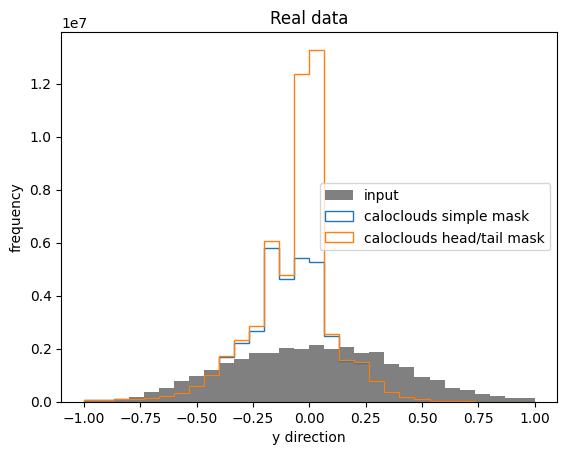

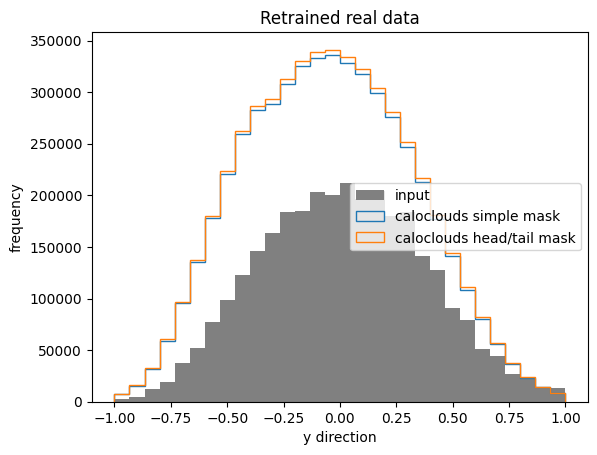

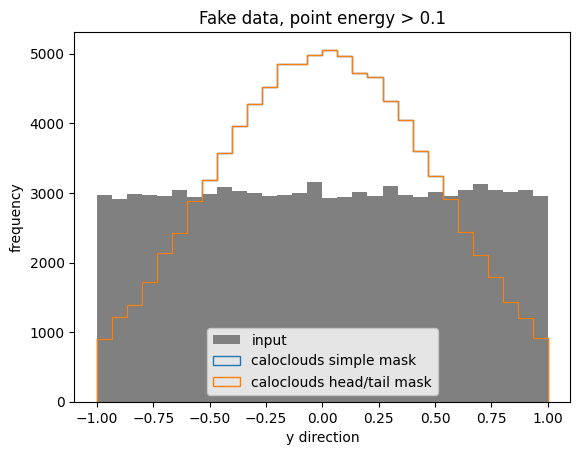

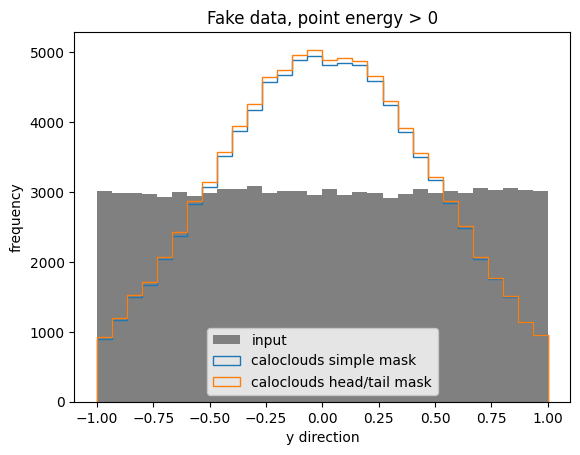

In [24]:
titles = ["Real data", "Retrained real data", "Fake data, point energy > 0.1", "Fake data, point energy > 0"]
for title, model_path in zip(titles, varients):
    dataset_path, n_events, points, hits_per_layer = varients[model_path]
    fig, ax = plt.subplots()
    
    # plot the input
    sum_hist_per_layer = np.sum(hits_per_layer, axis=0)
    x_min, x_max = -1, 1
    layer_bins = np.linspace(x_min, x_max, 31)
    layer_xs = 0.5*(layer_bins[1:] + layer_bins[:-1])
    ax.hist(layer_xs, weights=sum_hist_per_layer, bins=layer_bins, label="input", color="grey")
    
    # plot the frequencies using a simple mask that removes any negative energies
    found_es = points[:, :, 3].flatten()
    found_ys = points[:, :, 1].flatten()
    masked_ys = found_ys[found_es>0]
    ax.hist(masked_ys, histtype='step', label="caloclouds simple mask", bins=layer_bins)
    
    # plot the frequncies, masking by removing only training zeros
    flat_mask = tails_mask[model_path].flatten()
    ax.hist(found_ys[flat_mask], histtype='step', label="caloclouds head/tail mask", bins=layer_bins)
    ax.legend()
    ax.set_xlabel("y direction")
    ax.set_ylabel("frequency")
    ax.set_title(title)



Text(0.5, 1.0, 'Event 0, raw showerflow output')

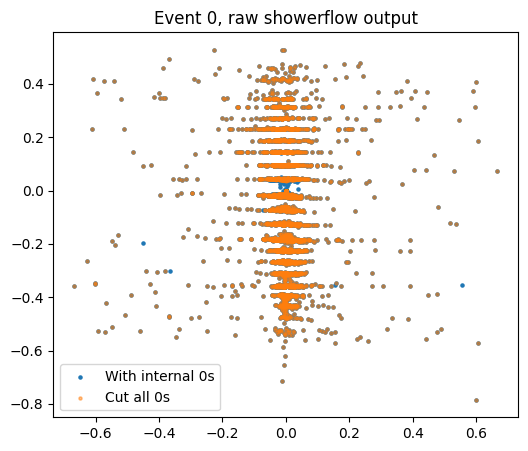

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

model_path = "../../../point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_07_23__11_59_44/ckpt_0.342419_1540000.pt"
#model_path = "../../../point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_08_21__16_20_29/ckpt_0.508328_320000.pt"
rd_points = varients[model_path][2]
event_0 = rd_points[0]
mask = tails_mask[model_path][0]
xs = event_0[:, 0][mask]
ys = event_0[:, 1][mask]
size=5
ax1.scatter(xs, ys, label="With internal 0s", s=size)
mask = event_0[:, 3] >= 0
xs = event_0[:, 0][mask]
ys = event_0[:, 1][mask]
ax1.scatter(xs, ys, alpha=0.5, s=size, label="Cut all 0s")
ax1.legend()
ax1.set_title("Event 0, raw showerflow output")

[]

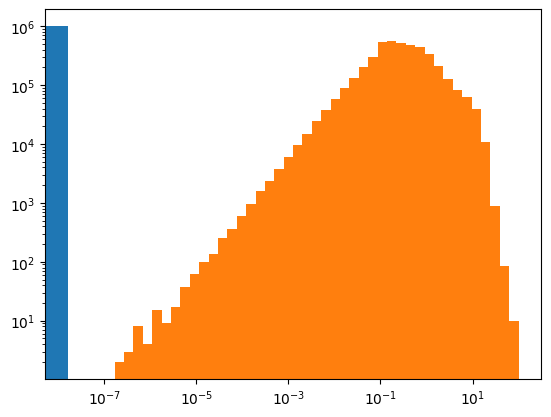

In [19]:
mask = tails_mask[model_path]
energies = rd_points[:, :, 3][mask]
energies2 = rd_points[:, :, 3][rd_points[:, :, 3]>0]
bins = np.logspace(np.log10(0.00000001), np.log10(100), 50)
bins[0] = -10
plt.hist(energies, bins=bins)
plt.hist(energies2, bins=bins)
plt.loglog()